In [1]:
from datasets import load_dataset
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
from sklearn.model_selection import train_test_split
from transformers import Trainer, TrainingArguments
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, balanced_accuracy_score
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, Subset
from transformers import EarlyStoppingCallback
from sklearn.model_selection import StratifiedKFold 
import numpy as np
from datasets import Dataset, DatasetDict, ClassLabel

/home/elson/factcheck/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = load_dataset('csv',data_files='dataset_propositionattribution_nerfeatures.csv',delimiter=',',column_names=["claim","premise","label","category","count_bf","count_ca","count_dis","count_food","count_lipid","count_treat","pres_bf","pres_ca","pres_dis","pres_food","pres_lipid","pres_treat","counte_bf","counte_ca","counte_dis","counte_food","counte_lipid","counte_treat","prese_bf","prese_ca","prese_dis","prese_food","prese_lipid","prese_treat","url", "entities","entity_map","entity_map_ev","entities_ev","gem_exp","gem_label","gpt_label","gpt_exp","gold_exp","synonym","voice","split"],skiprows=1)

Using custom data configuration default-022bc67e9c58e92d
Reusing dataset csv (/home/elson/.cache/huggingface/datasets/csv/default-022bc67e9c58e92d/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58)
100%|██████████| 1/1 [00:00<00:00, 200.21it/s]


In [3]:
train_dataset = dataset['train'].filter(lambda example: example['split'] == 'train')
validation_dataset = dataset['train'].filter(lambda example: example['split'] == 'validation')
test_dataset = dataset['train'].filter(lambda example: example['split'] == 'test')
dataset = DatasetDict({
    'train': train_dataset,
    'val': validation_dataset,
    'test': test_dataset
})

Loading cached processed dataset at /home/elson/.cache/huggingface/datasets/csv/default-022bc67e9c58e92d/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-2b8e361375c0e153.arrow
Loading cached processed dataset at /home/elson/.cache/huggingface/datasets/csv/default-022bc67e9c58e92d/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-0cc9bb699c2761fb.arrow
Loading cached processed dataset at /home/elson/.cache/huggingface/datasets/csv/default-022bc67e9c58e92d/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-608a44ac65076739.arrow


In [4]:
columns_to_keep = ["claim", "premise", "label","category"]
all_columns = dataset["train"].column_names

columns_to_drop = [col for col in all_columns if col not in columns_to_keep]
for split in dataset.keys():
    dataset[split] = dataset[split].remove_columns(columns_to_drop)

In [5]:
dataset

DatasetDict({
    train: Dataset({
        features: ['claim', 'premise', 'label', 'category'],
        num_rows: 1623
    })
    val: Dataset({
        features: ['claim', 'premise', 'label', 'category'],
        num_rows: 465
    })
    test: Dataset({
        features: ['claim', 'premise', 'label', 'category'],
        num_rows: 234
    })
})

In [6]:
from datasets import load_dataset, DatasetDict

label2id = {
    "contradiction": 2,
    "entailment": 0,
    "neutral": 1
}

id2label = {v: k for k, v in label2id.items()}

label_mapping = {
    'SUPPORTED': 'entailment',
    'REFUTED': 'contradiction',
    'NOT ENOUGH INFORMATION': 'neutral'
}

def map_and_encode_labels(example):
    # Map original dataset labels to new labels ('entailment', 'contradiction', 'neutral')
    mapped_label = label_mapping[example['label']]
    # Encode mapped labels using label2id
    example['label'] = label2id[mapped_label]
    return example

for split in dataset.keys():
    dataset[split] = dataset[split].map(map_and_encode_labels)

# Show the label encoding mapping
print("Label Encoding Mapping:", label2id)

Loading cached processed dataset at /home/elson/.cache/huggingface/datasets/csv/default-022bc67e9c58e92d/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-ec19dfd27de43963.arrow
Loading cached processed dataset at /home/elson/.cache/huggingface/datasets/csv/default-022bc67e9c58e92d/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-10d23eaef378d5d1.arrow
Loading cached processed dataset at /home/elson/.cache/huggingface/datasets/csv/default-022bc67e9c58e92d/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-e72c65ea7c63cdc8.arrow


Label Encoding Mapping: {'contradiction': 2, 'entailment': 0, 'neutral': 1}


In [7]:
dataset

DatasetDict({
    train: Dataset({
        features: ['claim', 'premise', 'label', 'category'],
        num_rows: 1623
    })
    val: Dataset({
        features: ['claim', 'premise', 'label', 'category'],
        num_rows: 465
    })
    test: Dataset({
        features: ['claim', 'premise', 'label', 'category'],
        num_rows: 234
    })
})

In [8]:
labels = np.array(dataset['train']['label'])

In [9]:
from transformers import AutoTokenizer
import torch.utils.data

class MediClaimDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, tokenizer_name='bioformers/bioformer-8L-mnli'):
        self.dataset = dataset
        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        idx = int(idx)  # Ensure idx is an integer
        item = self.dataset[idx]  # Access the dataset item at idx
        
        # Extracting claim and evidence texts

        claim = item['claim']
        evidences = item['premise']
        item['premise']=evidences
        item['claim']=claim
        # Tokenize the texts
        inputs = self.tokenizer(
            evidences, claim,
            return_tensors="pt",  # Ensure PyTorch tensors are returned
            padding='max_length',  # Apply padding to the maximum length
            truncation='longest_first',  # Truncate to the maximum length if necessary
            max_length=512,  # Specify the maximum length
            add_special_tokens=True  # Add special tokens like [CLS], [SEP]
        )
        
        item['input_ids'] = inputs['input_ids'].squeeze()  # Remove batch dimension
        item['attention_mask']= inputs['attention_mask'].squeeze() # Remove batch dimension
        
        if 'label' in item:
            item['labels'] = torch.tensor(item['label'], dtype=torch.long)
        
        return item



In [10]:
import torch
print(torch.cuda.device_count())
print("Available GPUs:")
for i in range(torch.cuda.device_count()):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

1
Available GPUs:
GPU 0: Tesla V100-SXM2-32GB


In [11]:
model_name = "bioformers/bioformer-8L-mnli"
tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)
model = AutoModelForSequenceClassification.from_pretrained(model_name,
                                 num_labels=3, ignore_mismatched_sizes=True)
device = "cuda:0"
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32768, 512, padding_idx=0)
      (position_embeddings): Embedding(512, 512)
      (token_type_embeddings): Embedding(2, 512)
      (LayerNorm): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=512, out_features=512, bias=True)
              (key): Linear(in_features=512, out_features=512, bias=True)
              (value): Linear(in_features=512, out_features=512, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=512, out_features=512, bias=True)
              (LayerNorm): LayerNorm((512,), eps=1e-12, element

In [12]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    prec = precision_score(labels, preds, average="weighted")  # Specify average method
    recall = recall_score(labels, preds, average="weighted")  # Specify average method

    return {"accuracy": acc, "precision": prec, "recall": recall, "f1": f1}

In [13]:
dataset['train']

Dataset({
    features: ['claim', 'premise', 'label', 'category'],
    num_rows: 1623
})

In [14]:
import gc

torch.cuda.set_device(0)

# Clearing the cache
torch.cuda.empty_cache()
gc.collect()
# Checking GPU memory, making sure to reset peak memory stats
torch.cuda.reset_peak_memory_stats()

In [15]:
current_device = torch.cuda.current_device()
print(f"Current CUDA device: GPU {current_device}")

Current CUDA device: GPU 0


In [16]:
train_data = dataset['train']
eval_data = dataset['val']
model = model.to('cuda:0')

In [17]:
tdata = MediClaimDataset(train_data)
vdata = MediClaimDataset(eval_data)
test_data = MediClaimDataset(dataset['test'])

In [18]:
tdata.__getitem__(0)

{'claim': 'Myrrh essential oil is sometimes used in skincare products to help improve the appearance of the skin.',
 'premise': 'The essential oils of frankincense and myrrh increase the fluidity of the lipid bilayer in the cuticle and change the orderly and dense structure to increase the permeability of the skin and decrease the barrier effect.',
 'label': 0,
 'category': 'General Health',
 'input_ids': tensor([  101,  1480,  3720, 15658,  1431,  2132,  4765,  2848,  9507,  1111,
          1435,  2573,  1109,  4258,  2161,  1425, 26267,  1431,  1425,  3460,
         14360,  1427,  1425, 26669,  1435,  2731,  1425,  2784,  1456,  1435,
         10036,  2700,  1446,  2161,  1425,  7805,  1431,  1425,  3550,  1435,
          3026,  1425,  6245,  1997,   119,   102, 31487,  4258,  3720,  6187,
          1478,  8811,  1822,  1427,  3550,  5183,  4030,  1446,  3346,  2520,
          1425,  6875,  1431,  1425,  3550,   119,   102,     0,     0,     0,
             0,     0,     0,     0,   

In [19]:
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments,DataCollatorWithPadding


data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding=True)


training_args = TrainingArguments(
    output_dir=f'/home/elson/11.4.1_bioformer/',
    num_train_epochs=15,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    dataloader_pin_memory=True,
    dataloader_num_workers=4,
    fp16=True,
    warmup_ratio=0.1,
    weight_decay=0.1,
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none"
)

trainer = Trainer(
    model=model.to(device),
    args=training_args,
    train_dataset=tdata,
    eval_dataset=vdata,
    #tokenizer=tokenizer,
    #data_collator = data_collator,
    compute_metrics=compute_metrics
    #callbacks=[EarlyStoppingCallback(early_stopping_patience=3, early_stopping_threshold=0.01)]
)

# Training and Evaluation
trainer.train()
eval_result = trainer.evaluate(vdata)

# Save the best model and tokenizer
model.save_pretrained(f'/home/elson/11.4.1_bioformer/best_model')
tokenizer.save_pretrained(f'/home/elson/11.4.1_bioformer/best_model')


Using amp half precision backend
/home/elson/factcheck/lib/python3.6/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 1623
  Num Epochs = 15
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1530


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.831100,0.801122,0.643011,0.607100,0.643011,0.615050
2,0.609400,0.946945,0.595699,0.659861,0.595699,0.617690
3,0.354700,1.124198,0.651613,0.651831,0.651613,0.645558
4,0.151400,1.390462,0.643011,0.677494,0.643011,0.656332
5,0.182400,1.399811,0.666667,0.637720,0.666667,0.642504
6,0.110200,1.767818,0.651613,0.622283,0.651613,0.629775
7,0.046700,1.926944,0.651613,0.651304,0.651613,0.649907
8,0.033800,2.075726,0.632258,0.649941,0.632258,0.640031
9,0.048800,2.134717,0.653763,0.637841,0.653763,0.641650
10,0.090400,2.280915,0.647312,0.648571,0.647312,0.647298


***** Running Evaluation *****
  Num examples = 465
  Batch size = 16
Saving model checkpoint to /home/elson/11.4.1_bioformer/checkpoint-102
Configuration saved in /home/elson/11.4.1_bioformer/checkpoint-102/config.json
Model weights saved in /home/elson/11.4.1_bioformer/checkpoint-102/pytorch_model.bin
Deleting older checkpoint [/home/elson/11.4.1_bioformer/checkpoint-459] due to args.save_total_limit
Deleting older checkpoint [/home/elson/11.4.1_bioformer/checkpoint-765] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 465
  Batch size = 16
Saving model checkpoint to /home/elson/11.4.1_bioformer/checkpoint-204
Configuration saved in /home/elson/11.4.1_bioformer/checkpoint-204/config.json
Model weights saved in /home/elson/11.4.1_bioformer/checkpoint-204/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 465
  Batch size = 16
Saving model checkpoint to /home/elson/11.4.1_bioformer/checkpoint-306
Configuration saved in /home/elson/11.4.1_biofo

Configuration saved in /home/elson/11.4.1_bioformer/best_model/config.json
Model weights saved in /home/elson/11.4.1_bioformer/best_model/pytorch_model.bin
tokenizer config file saved in /home/elson/11.4.1_bioformer/best_model/tokenizer_config.json
Special tokens file saved in /home/elson/11.4.1_bioformer/best_model/special_tokens_map.json


('/home/elson/11.4.1_bioformer/best_model/tokenizer_config.json',
 '/home/elson/11.4.1_bioformer/best_model/special_tokens_map.json',
 '/home/elson/11.4.1_bioformer/best_model/vocab.txt',
 '/home/elson/11.4.1_bioformer/best_model/added_tokens.json',
 '/home/elson/11.4.1_bioformer/best_model/tokenizer.json')

In [20]:
model_path = "/home/elson/11.4.1_bioformer/best_model/"
model = AutoModelForSequenceClassification.from_pretrained(model_path).to('cuda:0')

# Evaluate on the test set
test_results = trainer.predict(test_data)

loading configuration file /home/elson/11.4.1_bioformer/best_model/config.json
Model config BertConfig {
  "_name_or_path": "/home/elson/11.4.1_bioformer/best_model/",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "finetuning_task": "mnli",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 512,
  "id2label": {
    "0": "entailment",
    "1": "neutral",
    "2": "contradiction"
  },
  "initializer_range": 0.02,
  "intermediate_size": 2048,
  "label2id": {
    "contradiction": 2,
    "entailment": 0,
    "neutral": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 8,
  "num_hidden_layers": 8,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.18.0",
  "type_vocab_siz

In [21]:
print(test_results)

PredictionOutput(predictions=array([[ 2.6504e+00, -1.5400e+00, -1.1729e+00],
       [ 1.8291e+00,  1.8027e+00, -3.5938e+00],
       [ 4.3750e+00, -2.2520e+00, -2.2031e+00],
       [-2.2324e+00, -1.1650e+00,  3.5859e+00],
       [ 4.2344e+00, -1.9580e+00, -2.1621e+00],
       [ 4.7344e+00, -1.8105e+00, -2.7734e+00],
       [ 4.5000e+00, -2.4688e+00, -2.0430e+00],
       [ 4.5664e+00, -1.5537e+00, -2.9609e+00],
       [ 3.2012e+00, -9.4287e-01, -2.5312e+00],
       [-5.5566e-01,  7.7295e-01,  1.5356e-01],
       [ 4.2812e+00, -3.0645e+00, -1.3633e+00],
       [ 4.6641e+00, -2.4297e+00, -2.1582e+00],
       [ 4.5938e+00, -1.6973e+00, -2.8730e+00],
       [ 4.6367e+00, -1.6514e+00, -3.0098e+00],
       [ 4.7070e+00, -1.5439e+00, -3.1152e+00],
       [-5.2686e-01,  1.4307e+00, -9.7754e-01],
       [ 4.7461e+00, -2.3379e+00, -2.3750e+00],
       [ 4.7031e+00, -2.0645e+00, -2.6230e+00],
       [ 4.4102e+00, -2.2383e+00, -2.2539e+00],
       [ 4.5195e+00, -2.0234e+00, -2.5039e+00],
       [ 2.

In [22]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
probabilities = torch.softmax(torch.tensor(test_results.predictions).to(torch.float32), dim=-1)
predictions = np.argmax(probabilities.numpy(), axis=1)

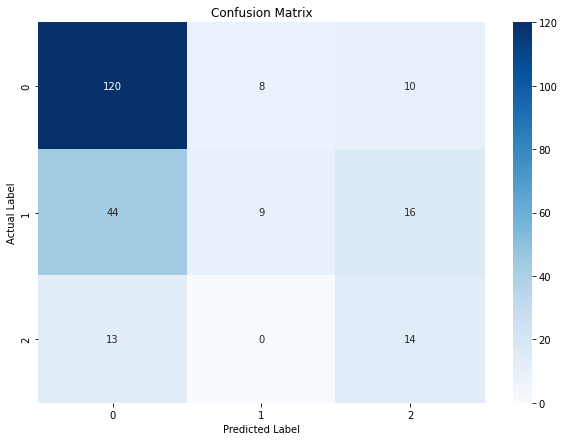

In [24]:
true_labels = test_results.label_ids
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")  # Adjust xticklabels and yticklabels as needed
plt.title("Confusion Matrix")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.show()


In [25]:
import pandas as pd
data_to_save = []
for idx in range(len(test_data)):
    item = test_data.__getitem__(idx)
    actual_label = item['label']
    predicted_label = predictions[idx]
    claim = item['claim'] 
    premise = item['premise'] 
    category = item['category']
    
    # Append the information as a dictionary to the list
    data_to_save.append({
        'Claim': claim,
        'Premise': premise,
        'Actual Label': actual_label,
        'Predicted Label': predicted_label,
        'Category' : category
    })

df = pd.DataFrame(data_to_save)

# Save the DataFrame to a CSV file
df.to_csv('/home/elson/results/11.4.1_results.csv', index=False)

In [26]:
# Calculate correctly classified instances
correctly_classified = df[df['Actual Label'] == df['Predicted Label']]

# Calculate misclassified instances
misclassified = df[df['Actual Label'] != df['Predicted Label']]

# Count the number of correctly classified and misclassified by category
correct_classification_counts = correctly_classified['Category'].value_counts()
misclassification_counts = misclassified['Category'].value_counts()

In [27]:
correct_classification_counts

General Health           37
Fitness                  12
Bone health              11
Skin                     10
Throat                    9
Cancer                    9
Cardiovascular Health     8
Diabetes                  8
Ear                       6
Neurological health       6
Blood                     5
Hair                      5
Women' s Health           4
Men's health              3
Eye                       3
Mental Health             3
COVID                     3
Muscles                   1
Name: Category, dtype: int64

In [28]:
misclassification_counts

General Health           14
Skin                     14
Bone health              10
Hair                      7
Eye                       6
Muscles                   5
Blood                     4
Diabetes                  4
Cardiovascular Health     4
COVID                     3
Men's health              3
Vascular                  3
Dental Health             3
Neurological health       3
Fitness                   3
Cancer                    3
Women' s Health           2
Name: Category, dtype: int64